In [1]:
import matplotlib.pyplot as plt
import numpy as np

import scripts.models.tcn_oneshot_multistep as tcn
from utils.data_preprocessing import (
    compare_feature_statistics,
    create_dataset,
    moving_average_causal_filter,
    normalise_dataset,
    split_train_test_forecast_windows,
)
from utils.dataset import SlowEarthquakeDataset
from utils.general_functions import set_seed, set_torch_device
from utils.nn_train import train_model
from utils.plotting import (
    plot_all_data_results,
    plot_metric_results,
    plot_original_vs_processed_data,
)

In [2]:
###### Simulated data training #########

In [3]:
SEED = 42
set_seed(SEED)

device = set_torch_device()

GPU name: NVIDIA A100-SXM4-40GB
Max GPU memory: 42.297786368 GiB


In [4]:
EXP = "sim_b698"

dataset = SlowEarthquakeDataset([EXP])
df = SlowEarthquakeDataset.convert_to_df(dataset, EXP)

df.head()

,obs_shear_stress,obs_normal_stress,time
0,10.656969,16.801851,0.00
1,10.658275,16.802265,0.01
2,10.659582,16.802679,0.02
3,10.660889,16.803091,0.03
4,10.662196,16.803503,0.04


In [5]:
shear_stress_df = df["obs_shear_stress"]
shear_stress_df.shape

(20000,)

In [6]:
SMOOTHING_WINDOW = 1
DOWNSAMPLING_FACTOR = 2
df_smoothed = moving_average_causal_filter(
    shear_stress_df, SMOOTHING_WINDOW, DOWNSAMPLING_FACTOR
)
df_smoothed.shape

(10000,)

In [7]:
results = compare_feature_statistics(shear_stress_df, df_smoothed)
results

{'mean_comparison': {'t_statistic': 0.003897796975239095,
  'p_value': 0.9968900417656372,
  'significant': False},
 'variance_comparison': {'f_statistic': 1.5192821265099376e-05,
  'p_value': 0.9968900419003165,
  'significant': False}}

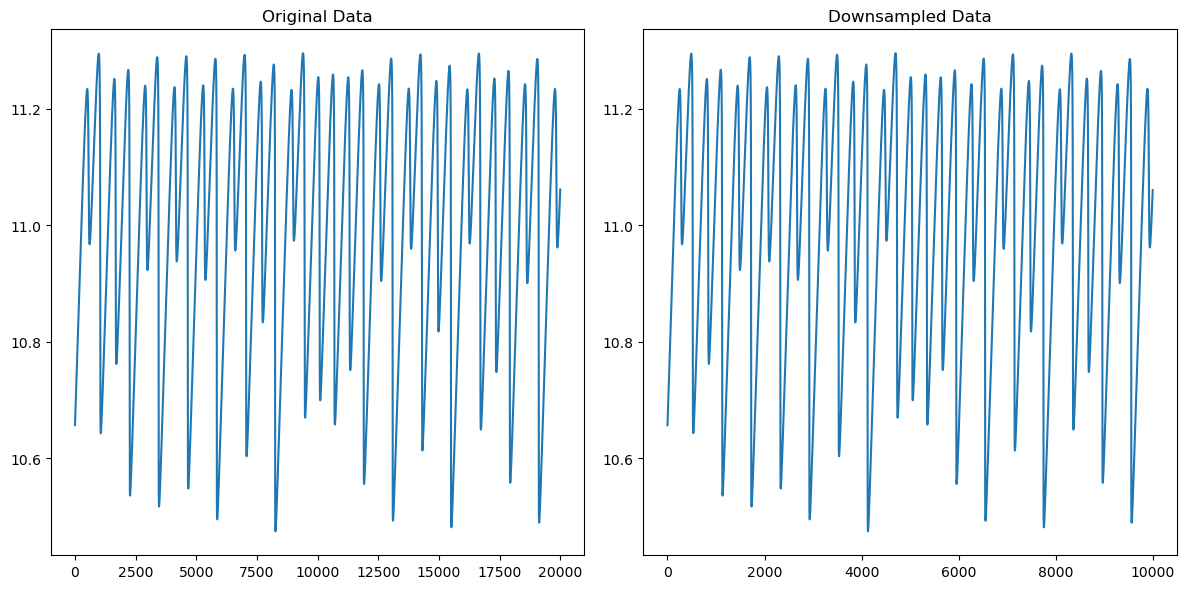

In [8]:
plot_original_vs_processed_data(
    shear_stress_df, df_smoothed, "line", "Downsampled"
)

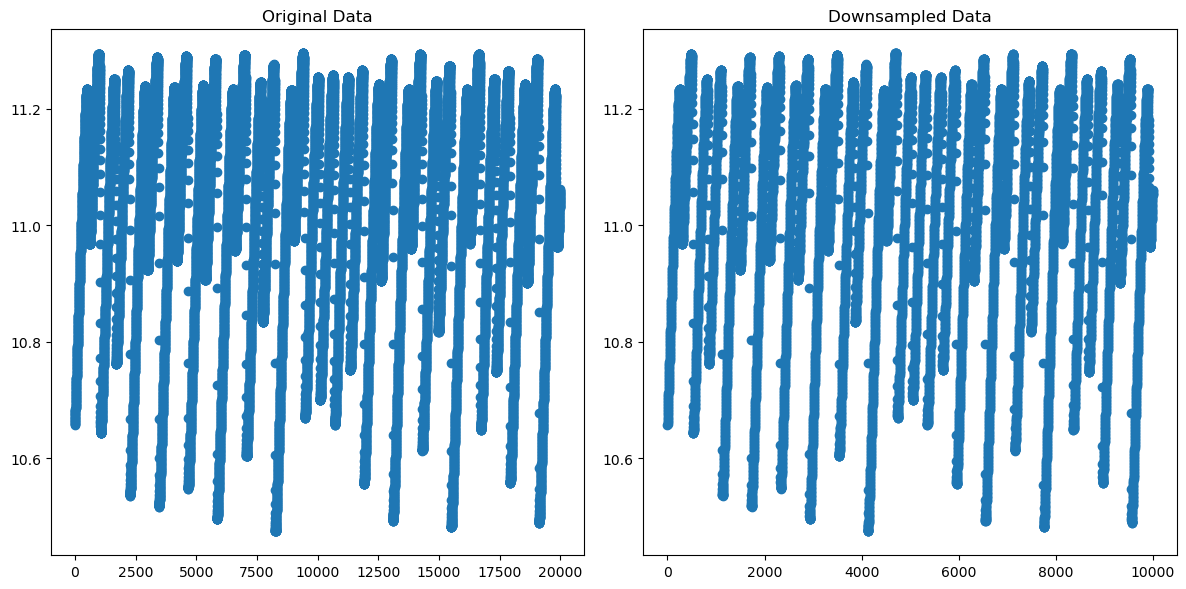

In [9]:
plot_original_vs_processed_data(
    shear_stress_df, df_smoothed, "scatter", "Downsampled"
)

In [10]:
LOOKBACK, FORECAST = 300, 30
N_FORECAST_WINDOWS = 60

X, y = create_dataset(df_smoothed, LOOKBACK, FORECAST)
print(f"X and y shapes: {X.shape}, {y.shape}")

X and y shapes: torch.Size([9671, 300]), torch.Size([9671, 30])


In [11]:
X_train, y_train, X_test, y_test = split_train_test_forecast_windows(
    X, y, FORECAST, N_FORECAST_WINDOWS
)

print(f"Training data shapes: {X_train.shape}, {y_train.shape}")
print(f"Testing data shapes: {X_test.shape}, {y_test.shape}")

Training data shapes: torch.Size([7860, 300]), torch.Size([7860, 30])
Testing data shapes: torch.Size([1800, 300]), torch.Size([1800, 30])


In [12]:
data_dict, scaler_X, scaler_y = normalise_dataset(
    X_train, y_train, X_test, y_test
)
data_dict.keys()

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'X_train_sc', 'y_train_sc', 'X_test_sc', 'y_test_sc'])

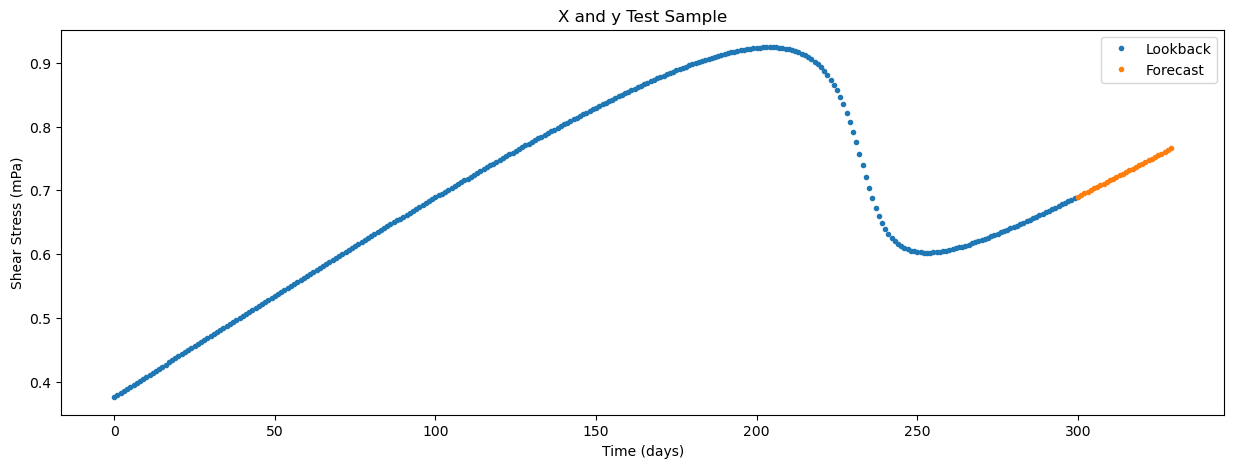

In [13]:
plt.figure(figsize=(15, 5))
plt.plot(data_dict["X_test_sc"][10], ".", label="Lookback")
plt.plot(
    np.arange(LOOKBACK, LOOKBACK + FORECAST),
    data_dict["y_test_sc"][10],
    ".",
    label="Forecast",
)
plt.title("X and y Test Sample")
plt.xlabel("Time (days)")
plt.ylabel("Shear Stress (mPa)")
plt.legend()
plt.show()

In [14]:
N_VARIATES = 1
HIDDEN_SIZE = 50
KERNEL_SIZE = 3
OUTPUT_SIZE = FORECAST
DROPOUT = 0

model = tcn.MultiStepTCN(
    N_VARIATES, LOOKBACK, OUTPUT_SIZE, [HIDDEN_SIZE], KERNEL_SIZE, DROPOUT
).to(device)

/home/users/p341cam/miniconda3/envs/venv/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [15]:
N_EPOCHS = 100
results_dict = train_model(model, N_EPOCHS, data_dict, scaler_y, device)

Training model on cuda


Epoch [100/100], Train RMSE: 0.0281, Test RMSE: 0.0280: 100%|█████████████| 100/100 [01:07<00:00,  1.48it/s]


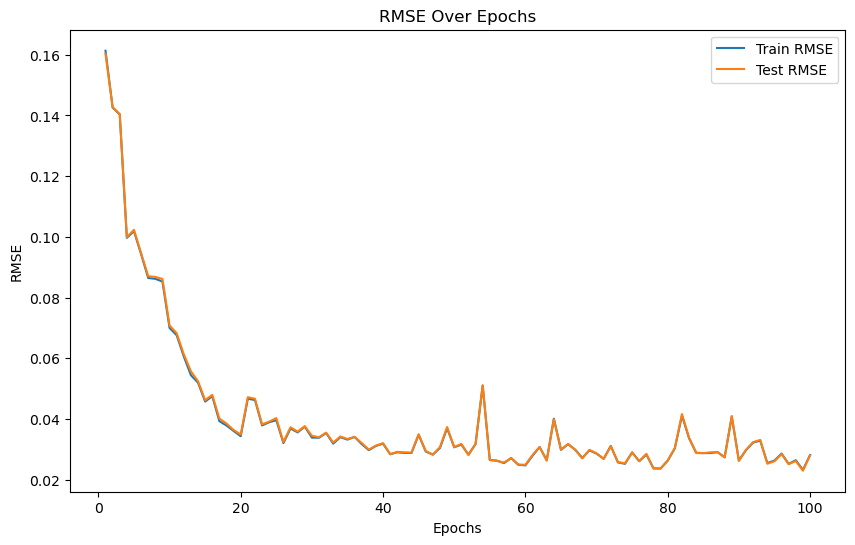

In [16]:
plot_metric_results(
    N_EPOCHS,
    results_dict["train_rmse_list"],
    results_dict["test_rmse_list"],
    "RMSE",
)

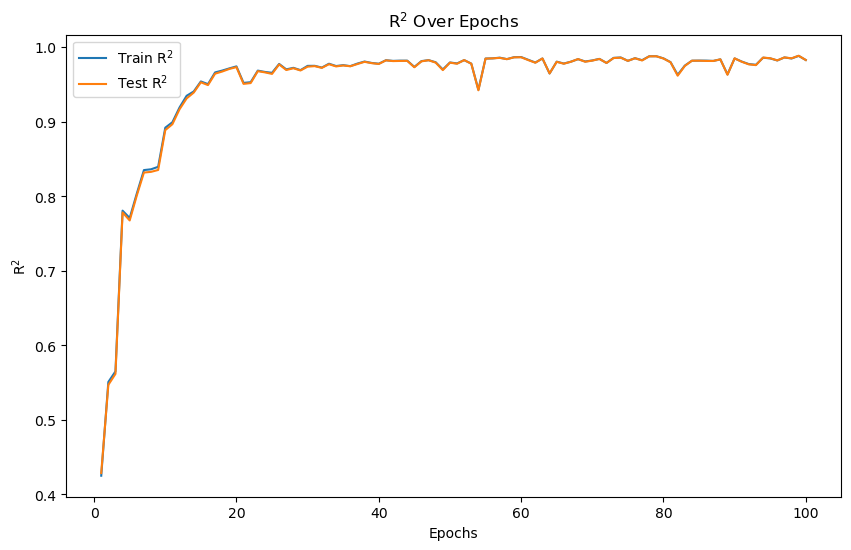

In [17]:
plot_metric_results(
    N_EPOCHS,
    results_dict["train_r2_list"],
    results_dict["test_r2_list"],
    "R$^2$",
)

In [18]:
TITLE = "Original Time Series and Model Predictions"
X_LABEL = "Time (days)"
Y_LABEL = "Shear Stress (mPa)"

ZOOM_MIN = 9010
ZOOM_MAX = 9500
ZOOM_WINDOW = [ZOOM_MIN, ZOOM_MAX]

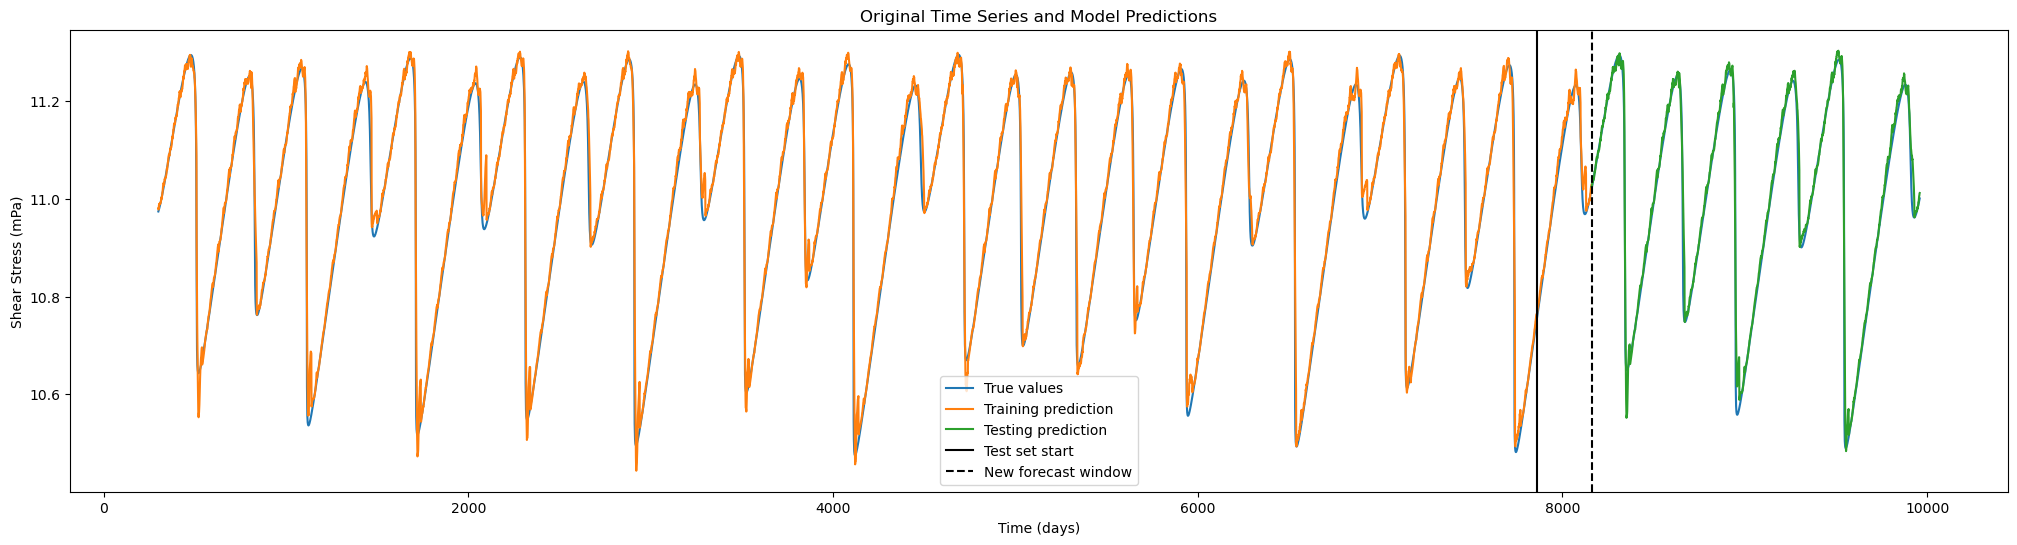

In [19]:
plot_all_data_results(
    data_dict, results_dict, LOOKBACK, FORECAST, TITLE, X_LABEL, Y_LABEL, []
)

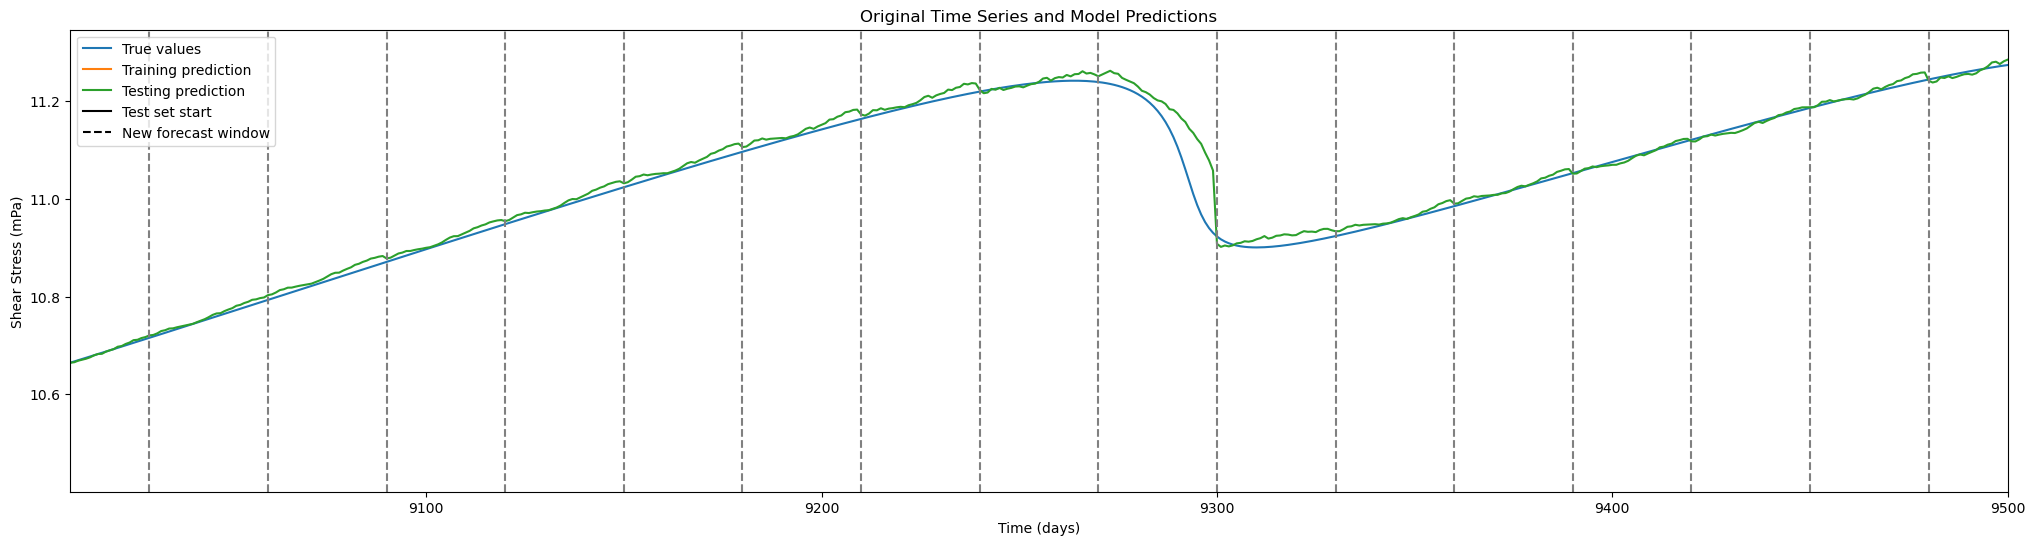

In [20]:
plot_all_data_results(
    data_dict,
    results_dict,
    LOOKBACK,
    FORECAST,
    TITLE,
    X_LABEL,
    Y_LABEL,
    ZOOM_WINDOW,
)

In [21]:
###### Lab data training #########

In [22]:
set_seed(SEED)

device = set_torch_device()

GPU name: NVIDIA A100-SXM4-40GB
Max GPU memory: 42.297786368 GiB


In [23]:
EXP = "b698"

dataset = SlowEarthquakeDataset([EXP])
df = SlowEarthquakeDataset.convert_to_df(dataset, EXP)

df.head()

,obs_shear_stress,obs_normal_stress,obs_ecdisp,obs_shear_strain,time
0,11.225116,17.382861,20.088637,22.167371,0.00
1,11.222870,17.375571,20.088683,22.167447,0.01
2,11.224972,17.385328,20.088975,22.167941,0.02
3,11.221124,17.373017,20.088549,22.167221,0.03
4,11.225461,17.386512,20.089116,22.168180,0.04


In [24]:
shear_stress_df = df["obs_shear_stress"]
shear_stress_df.shape

(20001,)

In [25]:
SMOOTHING_WINDOW = 1
DOWNSAMPLING_FACTOR = 2
df_smoothed = moving_average_causal_filter(
    shear_stress_df, SMOOTHING_WINDOW, DOWNSAMPLING_FACTOR
)
df_smoothed.shape

(10001,)

In [26]:
results = compare_feature_statistics(shear_stress_df, df_smoothed)
results

{'mean_comparison': {'t_statistic': 0.01129208583655751,
  'p_value': 0.9909904856087365,
  'significant': False},
 'variance_comparison': {'f_statistic': 0.00012751120251926028,
  'p_value': 0.9909904856229135,
  'significant': False}}

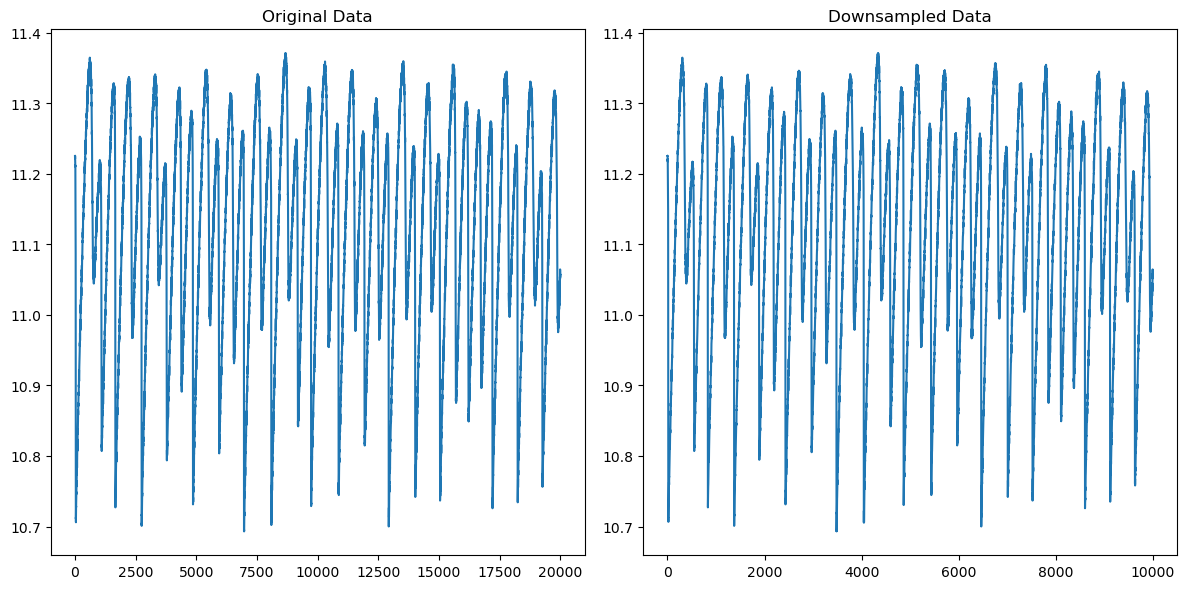

In [27]:
plot_original_vs_processed_data(
    shear_stress_df, df_smoothed, "line", "Downsampled"
)

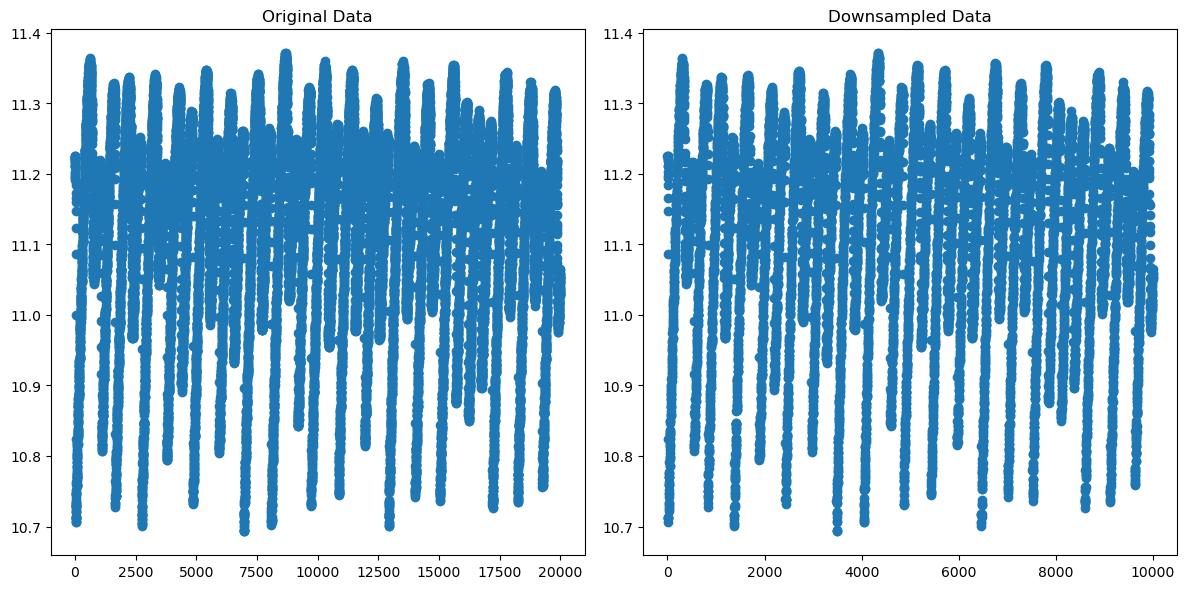

In [28]:
plot_original_vs_processed_data(
    shear_stress_df, df_smoothed, "scatter", "Downsampled"
)

In [29]:
LOOKBACK, FORECAST = 300, 30
N_FORECAST_WINDOWS = 60

X, y = create_dataset(df_smoothed, LOOKBACK, FORECAST)
print(f"X and y shapes: {X.shape}, {y.shape}")

X and y shapes: torch.Size([9672, 300]), torch.Size([9672, 30])


In [30]:
X_train, y_train, X_test, y_test = split_train_test_forecast_windows(
    X, y, FORECAST, N_FORECAST_WINDOWS
)

print(f"Training data shapes: {X_train.shape}, {y_train.shape}")
print(f"Testing data shapes: {X_test.shape}, {y_test.shape}")

Training data shapes: torch.Size([7860, 300]), torch.Size([7860, 30])
Testing data shapes: torch.Size([1800, 300]), torch.Size([1800, 30])


In [31]:
data_dict, scaler_X, scaler_y = normalise_dataset(
    X_train, y_train, X_test, y_test
)
data_dict.keys()

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'X_train_sc', 'y_train_sc', 'X_test_sc', 'y_test_sc'])

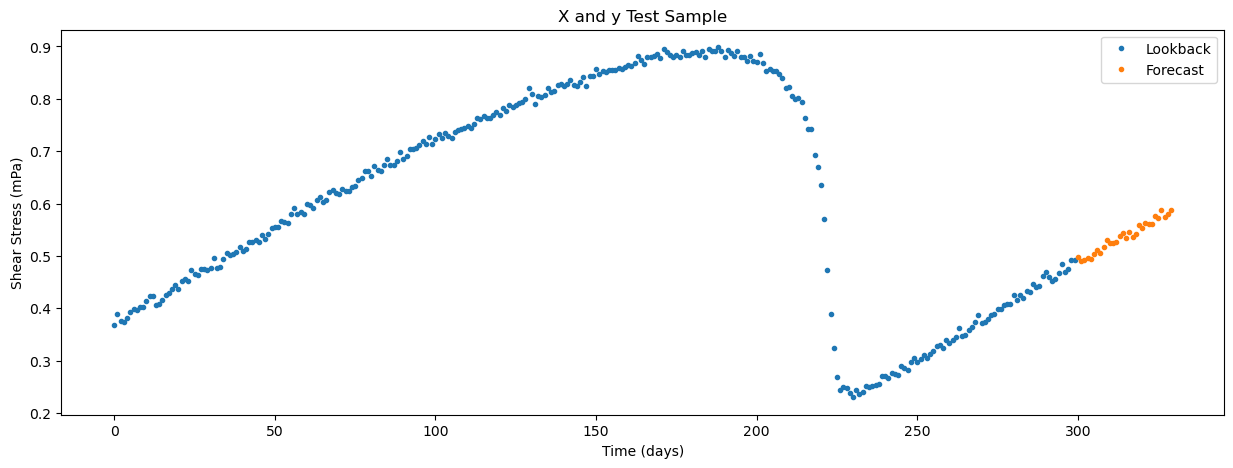

In [32]:
plt.figure(figsize=(15, 5))
plt.plot(data_dict["X_test_sc"][10], ".", label="Lookback")
plt.plot(
    np.arange(LOOKBACK, LOOKBACK + FORECAST),
    data_dict["y_test_sc"][10],
    ".",
    label="Forecast",
)
plt.title("X and y Test Sample")
plt.xlabel("Time (days)")
plt.ylabel("Shear Stress (mPa)")
plt.legend()
plt.show()

In [33]:
N_EPOCHS = 100
results_dict = train_model(model, N_EPOCHS, data_dict, scaler_y, device)

Training model on cuda


Epoch [100/100], Train RMSE: 0.0359, Test RMSE: 0.0402: 100%|█████████████| 100/100 [01:16<00:00,  1.30it/s]


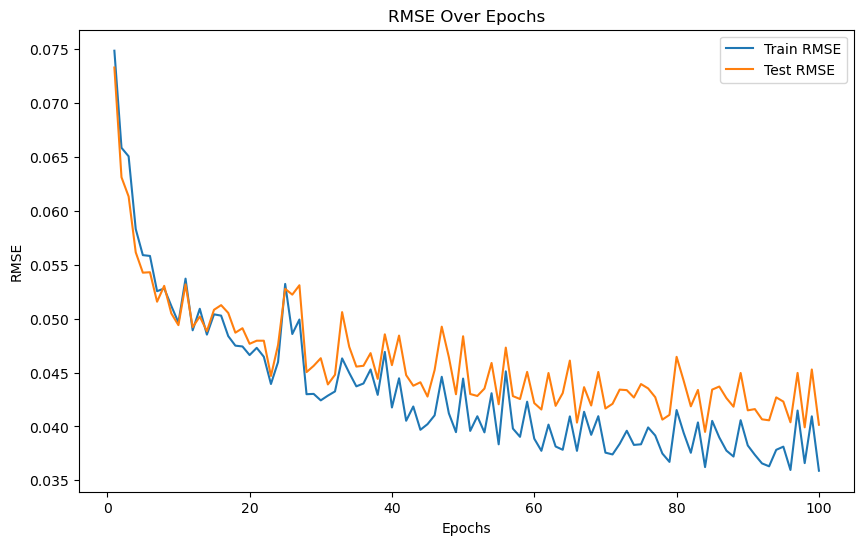

In [34]:
plot_metric_results(
    N_EPOCHS,
    results_dict["train_rmse_list"],
    results_dict["test_rmse_list"],
    "RMSE",
)

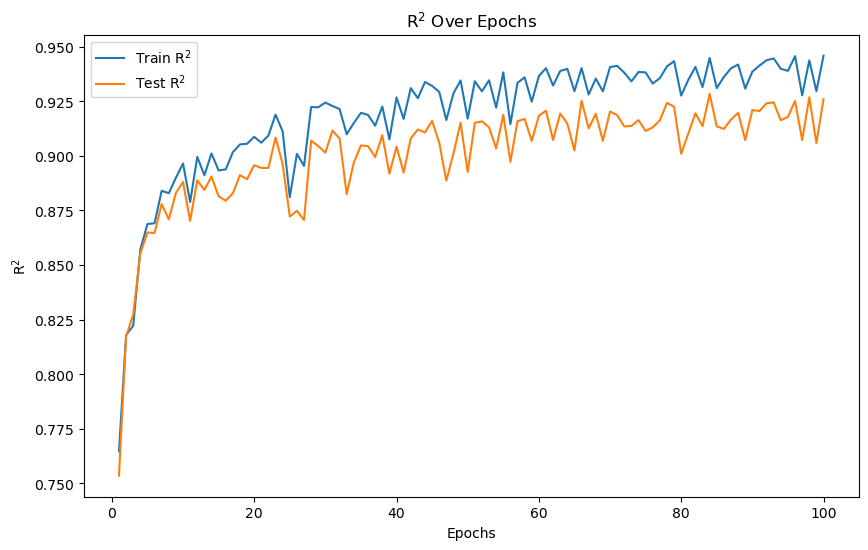

In [35]:
plot_metric_results(
    N_EPOCHS,
    results_dict["train_r2_list"],
    results_dict["test_r2_list"],
    "R$^2$",
)

In [36]:
TITLE = "Original Time Series and Model Predictions"
X_LABEL = "Time (days)"
Y_LABEL = "Shear Stress (mPa)"

ZOOM_MIN = 9010
ZOOM_MAX = 9500
ZOOM_WINDOW = [ZOOM_MIN, ZOOM_MAX]

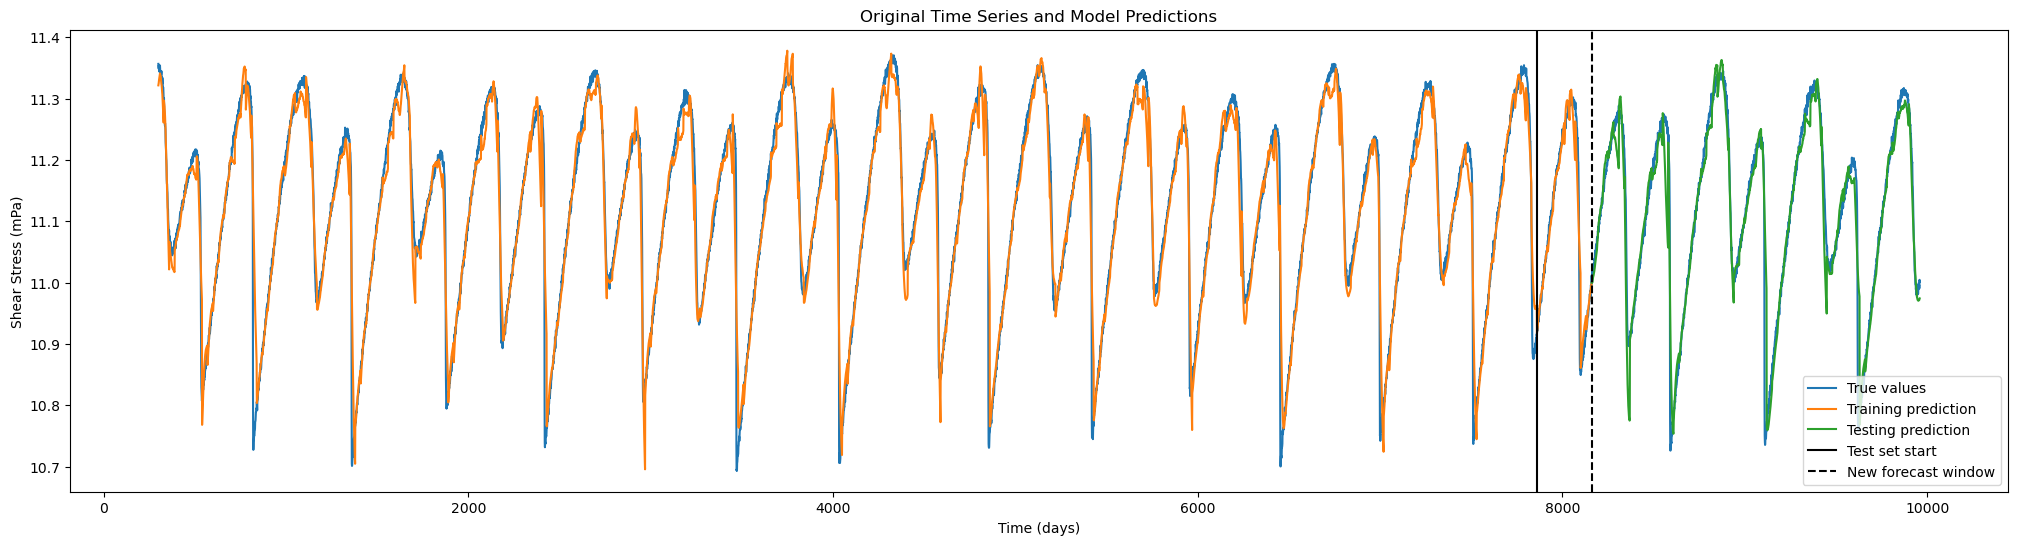

In [37]:
plot_all_data_results(
    data_dict, results_dict, LOOKBACK, FORECAST, TITLE, X_LABEL, Y_LABEL, []
)

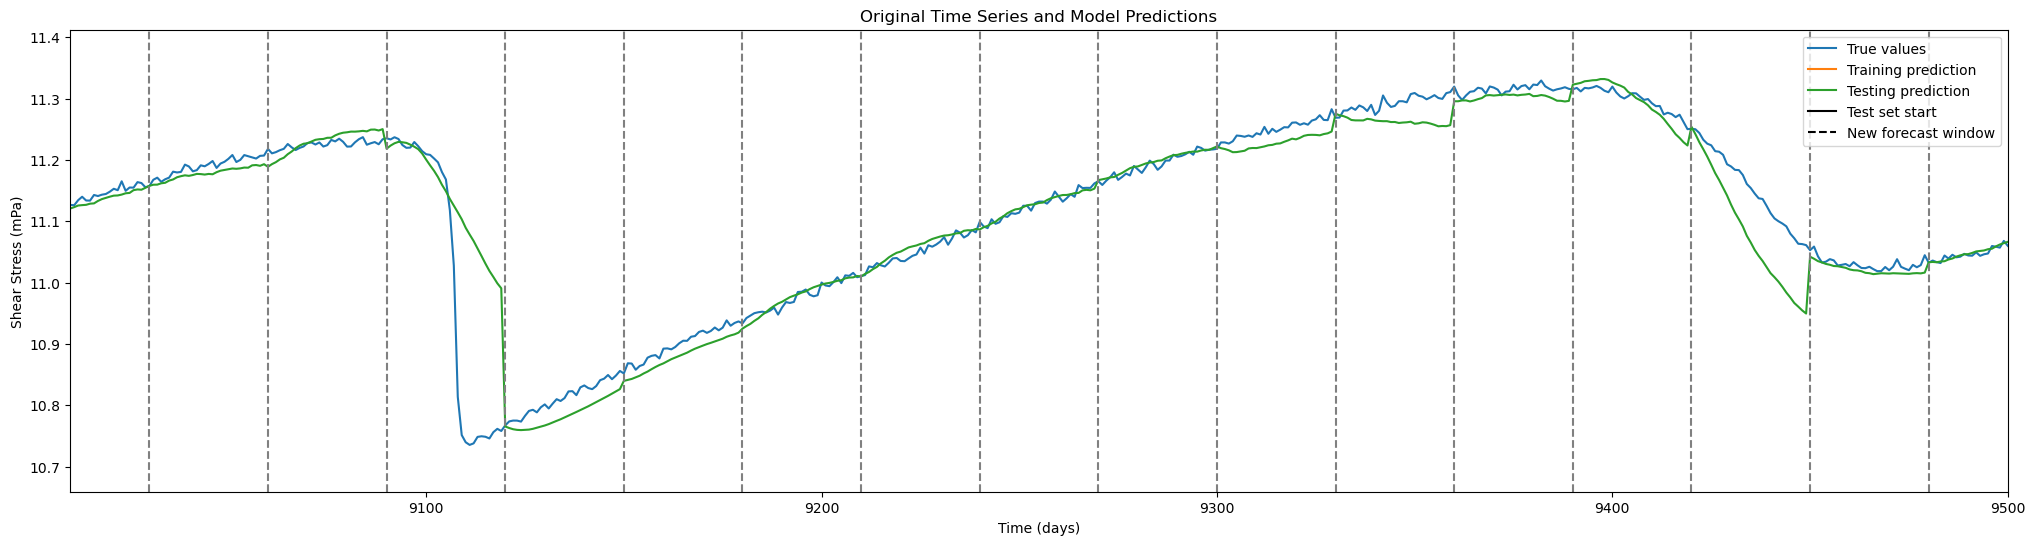

In [38]:
plot_all_data_results(
    data_dict,
    results_dict,
    LOOKBACK,
    FORECAST,
    TITLE,
    X_LABEL,
    Y_LABEL,
    ZOOM_WINDOW,
)

In [39]:
###### Regular Lab data training #########

In [40]:
set_seed(SEED)

device = set_torch_device()

GPU name: NVIDIA A100-SXM4-40GB
Max GPU memory: 42.297786368 GiB


In [41]:
N_VARIATES = 1
HIDDEN_SIZE = 50
KERNEL_SIZE = 3
OUTPUT_SIZE = FORECAST
DROPOUT = 0

model = tcn.MultiStepTCN(
    N_VARIATES, LOOKBACK, OUTPUT_SIZE, [HIDDEN_SIZE], KERNEL_SIZE, DROPOUT
).to(device)

/home/users/p341cam/miniconda3/envs/venv/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [42]:
N_EPOCHS = 100
results_dict = train_model(model, N_EPOCHS, data_dict, scaler_y, device)

Training model on cuda


Epoch [100/100], Train RMSE: 0.0359, Test RMSE: 0.0413: 100%|█████████████| 100/100 [01:09<00:00,  1.45it/s]


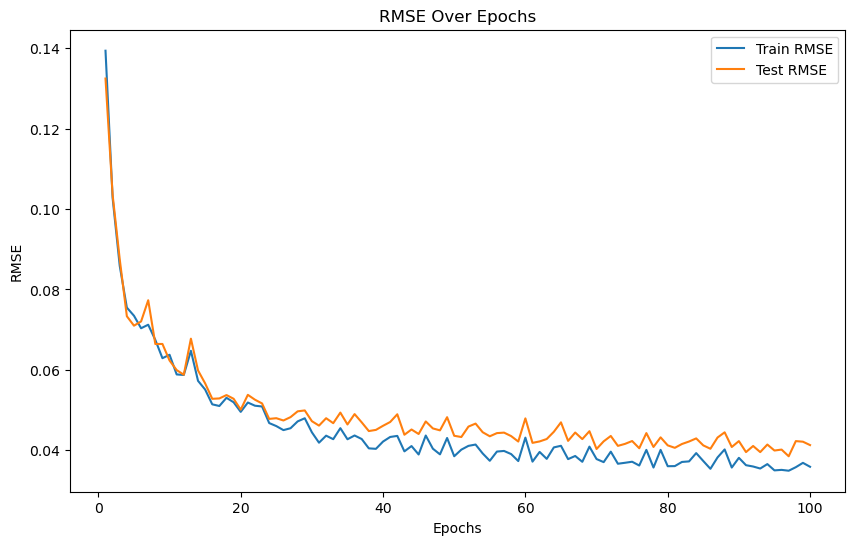

In [43]:
plot_metric_results(
    N_EPOCHS,
    results_dict["train_rmse_list"],
    results_dict["test_rmse_list"],
    "RMSE",
)

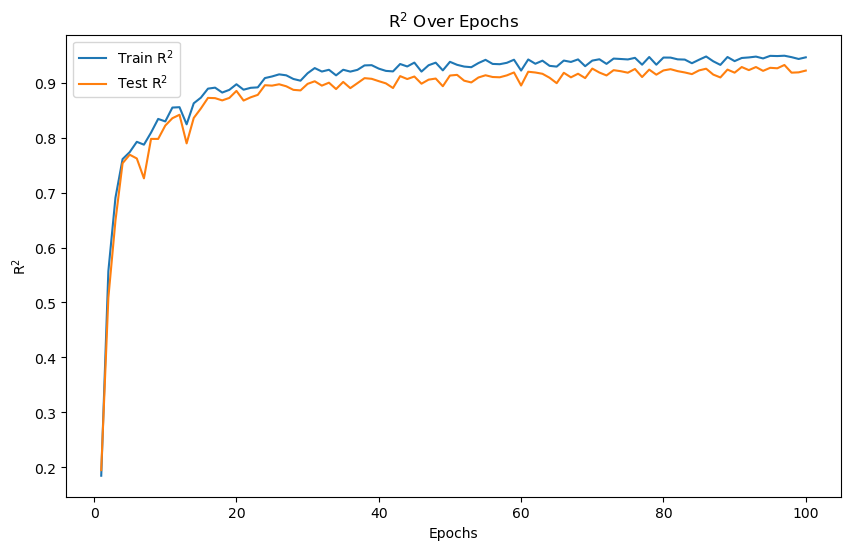

In [44]:
plot_metric_results(
    N_EPOCHS,
    results_dict["train_r2_list"],
    results_dict["test_r2_list"],
    "R$^2$",
)

In [45]:
TITLE = "Original Time Series and Model Predictions"
X_LABEL = "Time (days)"
Y_LABEL = "Shear Stress (mPa)"

ZOOM_MIN = 9010
ZOOM_MAX = 9500
ZOOM_WINDOW = [ZOOM_MIN, ZOOM_MAX]

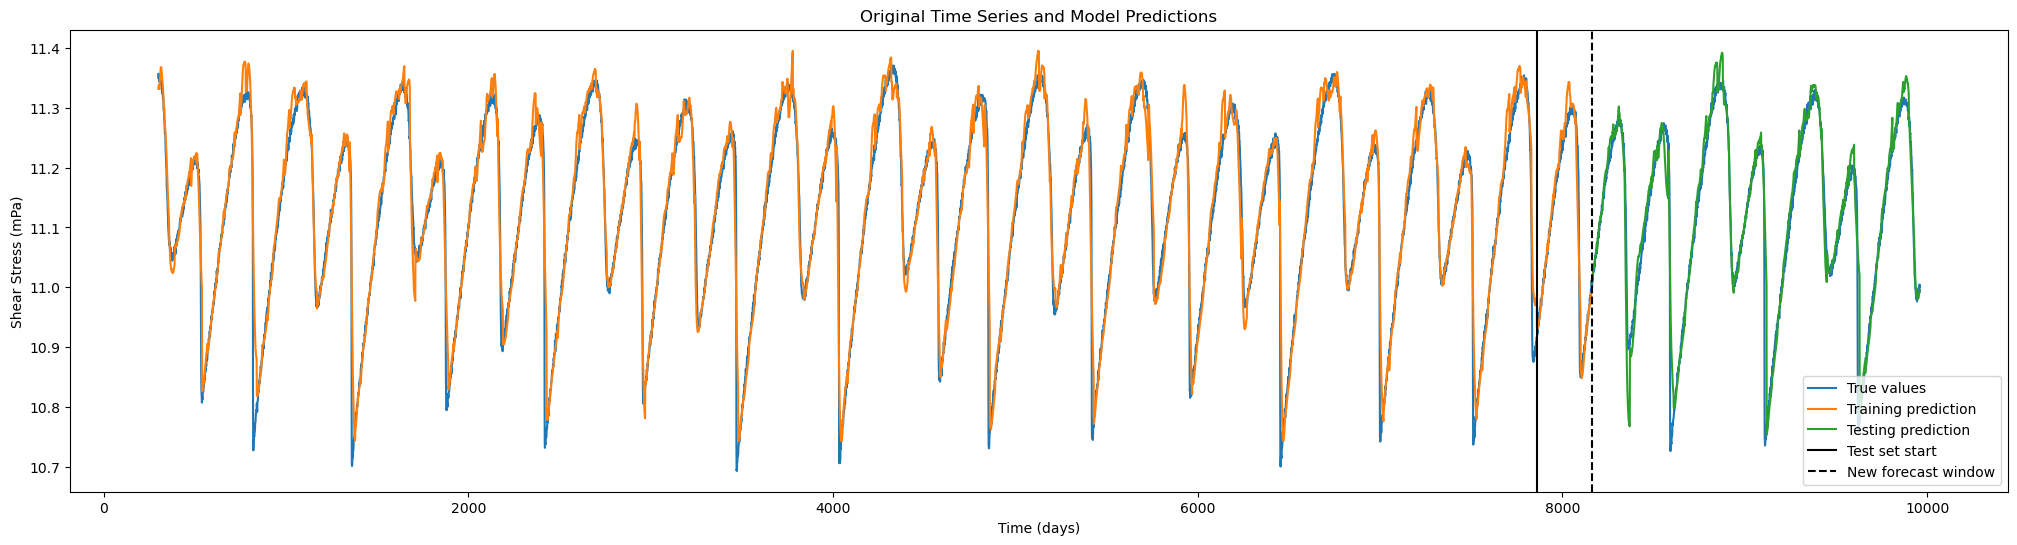

In [46]:
plot_all_data_results(
    data_dict, results_dict, LOOKBACK, FORECAST, TITLE, X_LABEL, Y_LABEL, []
)

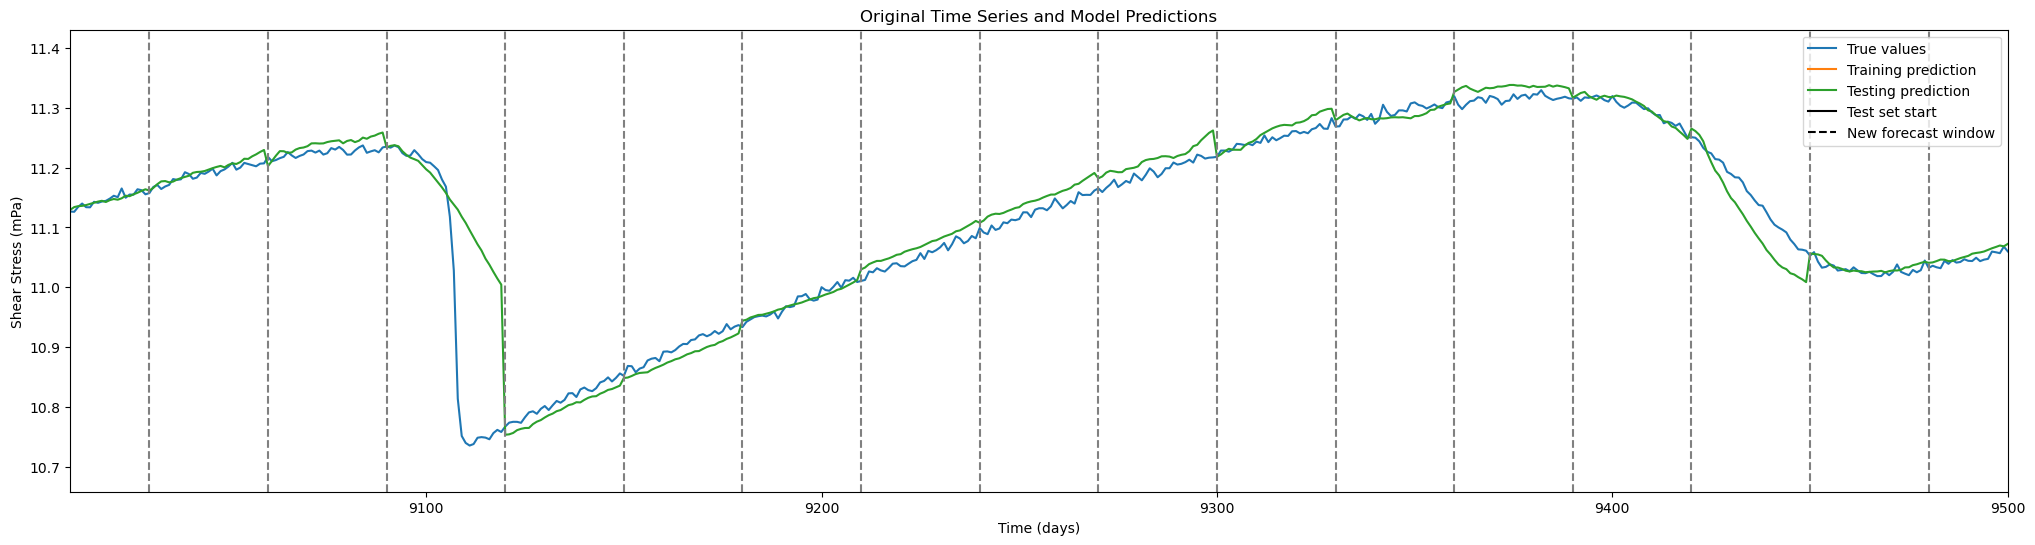

In [47]:
plot_all_data_results(
    data_dict,
    results_dict,
    LOOKBACK,
    FORECAST,
    TITLE,
    X_LABEL,
    Y_LABEL,
    ZOOM_WINDOW,
)